# Importing the necessary libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
import os
import pickle
# from imblearn.pipeline import make_pipeline
# from imblearn.pipeline import Pipeline as imb_pipe
# from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import BorderlineSMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
import numpy
import matplotlib
#df_data = pd.read_pickle("cohort_file.pickle")
data_dir = os.getcwd()
#print(data_dir)
#cohort_df = pd.read_csv(data_dir + '/data/chrtDf.csv')
#cohort_df = pd.read_csv(data_dir + '/data_binary_test/chrtDf.csv')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
cohort_df = pd.read_csv(data_dir + '/data_binary_v3/chrtDf.csv')
#cohort_df = pd.read_csv(data_dir + '/data/chrtDf.csv')
# Pnotes_df = pd.read_csv(data_dir + '/data/progNotes.csv')
# RedPath_df = pd.read_csv(data_dir+ '/data/radPathNotes.csv')
# SurgPath_df = pd.read_csv(data_dir+ '/data/surgPathNotes.csv')
Pnotes_df = pd.read_csv(data_dir + '/data_binary_v3/progNotes.csv')
RedPath_df = pd.read_csv(data_dir+ '/data_binary_v3/radPathNotes.csv')
SurgPath_df = pd.read_csv(data_dir+ '/data_binary_v3/surgPathNotes.csv')
cohort_df.rename(columns =  {'tnm_mixed_stage_desc' : 'levels'},inplace= True)
cohort_df = cohort_df.loc[cohort_df['pat_id']!='NOPE']
pat_count = cohort_df.groupby('pat_id').size().sort_values(ascending=False)
# single record seperation
patsWithOne = pat_count.loc[pat_count == 1]
chrtDfOne = cohort_df.loc[cohort_df['pat_id'].isin(list(patsWithOne.index))].reset_index()

chrtDfOne = chrtDfOne[chrtDfOne.levels != 'Unknown']
chrtDfOne = chrtDfOne[chrtDfOne.levels != 'Missing']
chrtDfOne = chrtDfOne[chrtDfOne.levels != 'Not Applicable']
#chrtDf = chrtDf[chrtDf['gender'].notnull()]
#chrtDf = chrtDf[chrtDf['bmi'].notnull()]

#stripping the subclass of cancer staging data; eg. 1A to 1
chrtDfOne['levels'] = chrtDfOne['levels'].apply(lambda x: x[0])
# chrtDfOne.info()
# chrtDfOne.groupby('pat_id').size().sort_values(ascending=False)
#chrtDf['levels'] = chrtDf['levels'].apply(lambda x:0 if int(x) <= 3 else 1)
#chrtDf['levels'] = chrtDf['levels'].apply(lambda x:-1 if int(x) <=1 else 1 if int(x) >=3 else 0)
chrtDfOne['levels'] = chrtDfOne['levels'].apply(lambda x: 0 if int(x) <= 3 else 1)
chrtDfOne.reset_index(drop = True, inplace = True)

In [4]:
Pnotes_df['tnm_hits'].sum()

2212

In [ ]:
Pnotes_df

# Data pre-processing and filtering columns that will be used in the learning model

In [16]:

chrtDf = chrtDfOne[['site_group','prog_stage_1_hits', 'prog_stage_2_hits', \
                    'prog_stage_3_hits','prog_stage_4_hits','prog_tnm_hits', 'prog_stage_lmt_hits', 'prog_stage_adv_hits',\
                    'prog_stage_ext_hits','prog_stage_met_hits','prog_stage_early_hits','rad_path_stage_1_hits',\
                    'rad_path_stage_2_hits', 'rad_path_stage_3_hits','rad_path_stage_4_hits', 'rad_path_stage_lmt_hits',\
                    'rad_path_stage_adv_hits','rad_path_stage_ext_hits','rad_path_stage_met_hits', 'rad_path_tnm_hits',\
                     'rad_path_stage_early_hits','surg_path_stage_1_hits', 'surg_path_stage_2_hits',\
                    'surg_path_stage_3_hits', 'surg_path_stage_4_hits', 'surg_path_stage_lmt_hits',\
                    'surg_path_stage_adv_hits','surg_path_stage_ext_hits','surg_path_stage_met_hits',\
                    'surg_path_stage_early_hits' ,'surg_path_tnm_hits', 'levels']]

In [17]:
chrtDf.groupby(['levels']).size().sum()

1863

# Selecting the broad features to use

In [18]:
#Each report has to be taken into consideration separately
#report : Progress report for breast cancer
col2use =  ['prog_stage_1_hits', 'prog_stage_2_hits', 'prog_stage_3_hits','prog_stage_4_hits','prog_tnm_hits', 'prog_stage_lmt_hits', 'prog_stage_adv_hits',\
            'prog_stage_ext_hits','prog_stage_met_hits','prog_stage_early_hits','rad_path_stage_1_hits','rad_path_stage_2_hits', 'rad_path_stage_3_hits','rad_path_stage_4_hits', 'rad_path_stage_lmt_hits',\
            'rad_path_stage_adv_hits','rad_path_stage_ext_hits','rad_path_stage_met_hits', 'rad_path_tnm_hits','rad_path_stage_early_hits','surg_path_stage_1_hits', 'surg_path_stage_2_hits',\
             'surg_path_stage_3_hits', 'surg_path_stage_4_hits', 'surg_path_stage_lmt_hits','surg_path_stage_adv_hits','surg_path_stage_ext_hits','surg_path_stage_met_hits',\
              'surg_path_stage_early_hits' ,'surg_path_tnm_hits']
X_proc = chrtDf[col2use]
Y = chrtDf['levels']


#### Combine the stage 1,2,3 in one and 4 in other

In [19]:
colProgMet = ['prog_stage_4_hits', 'prog_stage_adv_hits','prog_stage_ext_hits','prog_stage_met_hits', 'prog_stage_lmt_hits']
colProgNonMet = ['prog_stage_1_hits', 'prog_stage_2_hits','prog_stage_3_hits','prog_stage_early_hits']

colRadMet = ['rad_path_stage_4_hits', 'rad_path_stage_adv_hits','rad_path_stage_ext_hits','rad_path_stage_met_hits',\
            'rad_path_stage_lmt_hits']
             
colRadNonMet = ['rad_path_stage_1_hits', 'rad_path_stage_2_hits','rad_path_stage_3_hits',\
                'rad_path_stage_early_hits']

colSurgMet = ['surg_path_stage_4_hits', 'surg_path_stage_adv_hits','surg_path_stage_ext_hits','surg_path_stage_met_hits',\
             'surg_path_stage_lmt_hits',]
colSurgNonMet = ['surg_path_stage_1_hits', 'surg_path_stage_2_hits','surg_path_stage_3_hits',\
                 'surg_path_stage_early_hits']


X_proc['Prog_Metastasis']= X_proc[colProgMet].apply(lambda x: sum(x), axis =1)
X_proc['Prog_NonMetastasis'] = X_proc[colProgNonMet].apply(lambda x: sum(x), axis =1)
X_proc['Rad_Metastasis'] = X_proc[colRadMet].apply(lambda x: sum(x), axis =1)
X_proc['Rad_NonMetastasis'] = X_proc[colRadNonMet].apply(lambda x: sum(x), axis =1)
X_proc['Surg_Metastasis'] = X_proc[colSurgMet].apply(lambda x: sum(x), axis =1)
X_proc['Surg_NonMetastasis'] = X_proc[colSurgNonMet].apply(lambda x: sum(x), axis =1)


/home/dbasu/.local/share/virtualenvs/debraj_notebook-uSskSi2b/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Defining the feature variables X and dependent (target) variable y

In [20]:
X = X_proc[['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', 'Surg_NonMetastasis'\
       ,'prog_tnm_hits','rad_path_tnm_hits','surg_path_tnm_hits']]
# X = X_proc[['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', \
#             'Surg_NonMetastasis' ]]
y = chrtDf['levels']

In [21]:
X_exploration= pd.DataFrame()

X_exploration =X_proc[['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', 'Surg_NonMetastasis'\
       ,'prog_tnm_hits','rad_path_tnm_hits','surg_path_tnm_hits']]
X_exploration['Metastasis']= y
data= X_exploration.values

/home/dbasu/.local/share/virtualenvs/debraj_notebook-uSskSi2b/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [28]:
print(X_exploration[['Rad_Metastasis', 'Metastasis']].groupby('Metastasis').sum())
print(X_exploration[['Rad_NonMetastasis', 'Metastasis']].groupby('Metastasis').sum())

            Rad_Metastasis
Metastasis                
0                   3284.0
1                   3989.0
            Rad_NonMetastasis
Metastasis                   
0                        94.0
1                        44.0


In [ ]:
import matplotlib.pyplot as plt
plt.bar(X_exploration[['surg_path_tnm_hits', 'Metastasis']].groupby('Metastasis').sum(), height= 1)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
for r in X_exploration.columns[:-1]:
    feature = r
    print(feature)
    plt.figure()
    sns.kdeplot(X_exploration[X_exploration['Metastasis']==0][feature].values, legend= True, shade= True)
    sns.kdeplot(X_exploration[X_exploration['Metastasis']==1][feature].values, legend= True, shade= True)
    plt.legend(['No', 'Yes'])
    plt.ylabel('Distribution density')
    plt.xlabel('Counts')
    t = feature + ' distribution of metastasis stage (No/Yes)'
    plt.title(t)
    plt.savefig(feature + '.png',dpi=300, bbox_inches='tight' )


In [ ]:
X_exploration

### Number of features : 9

In [8]:
ForCorr = X_proc[['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', \
                  'Surg_NonMetastasis','prog_tnm_hits','rad_path_tnm_hits','surg_path_tnm_hits']]
# ForCorr = X_proc[['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', \
#                   'Surg_NonMetastasis']]
ForCorr['levels'] = chrtDf['levels']
Feature_column= ['Prog_Metastasis', 'Prog_NonMetastasis', 'Rad_Metastasis','Rad_NonMetastasis', 'Surg_Metastasis', \
                  'Surg_NonMetastasis','prog_tnm_hits','rad_path_tnm_hits','surg_path_tnm_hits']

/home/dbasu/.local/share/virtualenvs/debraj_notebook-uSskSi2b/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
ForCorr.groupby(['prog_tnm_hits','levels']).size()

#### Correlation analysis

In [ ]:
cordata = ForCorr.corr()
cor_target = abs(cordata["levels"])
#Selecting highly correlated features
relevant_features = cor_target
relevant_features.sort_values(ascending = False,inplace = True)
relevant_features

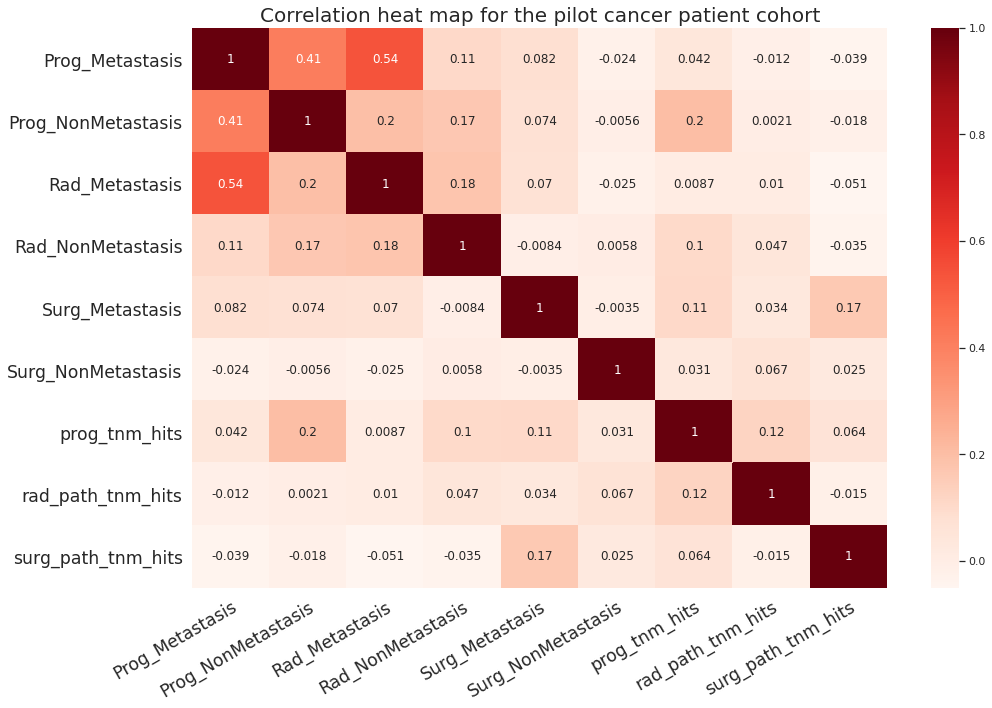

In [12]:
#Using Pearson Correlation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale= 1)
plt.figure(figsize=(15,10))
cor = ForCorr[Feature_column].corr()
# ax.set_ylim([0,2])
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.01 # Add 0.5 to the bottom
t -= 0.01 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xticks(
    rotation=30, 
    horizontalalignment='right',
    fontsize='x-large' ,  rotation_mode="anchor"
)
plt.yticks(
    rotation=0, 
    horizontalalignment='right', rotation_mode="anchor",
    fontsize='x-large'
)
plt.title('Correlation heat map for the pilot cancer patient cohort', fontsize = 20)
plt.tight_layout()
plt.savefig('CorrHeatMap_pilot.png', dpi=300, bbox_inches='tight')
# plt.show()

#### plots of feature distribution along the labels

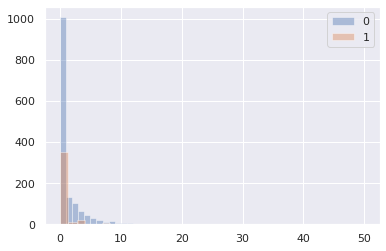

In [55]:
sns.distplot(ForCorr[ForCorr['levels']==0]['prog_tnm_hits'].values, hist= True, kde= False)
sns.distplot(ForCorr[ForCorr['levels']==1]['prog_tnm_hits'].values, hist= True, kde= False)
plt.legend(['0', '1'])

#### KS test

In [11]:
from scipy.stats import ks_2samp
import numpy as np
FeatureSelection = pd.DataFrame(columns =('Feature','KS score', 'P-value'))
stat_columns = Feature_column
for f in stat_columns:
    [stat, p]= ks_2samp(ForCorr[f], ForCorr['levels'])
    FeatureSelection = FeatureSelection.append({'Feature': f, 'KS score': stat,'P-value': p}, ignore_index=True)

FeatureSelection
p =0.01
FeatureSelection = FeatureSelection[FeatureSelection['P-value'] <= p]
FeatureSelection.reset_index(drop = True, inplace = True)
print(FeatureSelection)


              Feature  KS score        P-value
0     Prog_Metastasis  0.677431   0.000000e+00
1  Prog_NonMetastasis  0.349295  5.336187e-292
2      Rad_Metastasis  0.426132   0.000000e+00
3   Rad_NonMetastasis  0.143096   1.683885e-48
4     Surg_Metastasis  0.235338  3.109828e-131
5  Surg_NonMetastasis  0.185969   8.107132e-82
6       prog_tnm_hits  0.200631   2.998649e-95
7   rad_path_tnm_hits  0.174647   3.690532e-72
8  surg_path_tnm_hits  0.166667   1.007911e-65


In [88]:
X.shape

(1863, 9)

### Running Grid search for hyper-parameter tuning in Random Forest (RF) no SMOTE

In [ ]:
#Cross validation using grid-search method will remove the need for splitting the samples into train, validation and test sets
#separately
from sklearn.model_selection import train_test_split
import numpy as np
import random
random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc 
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc  , precision_recall_curve, confusion_matrix
import random
#Scale the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
from sklearn import metrics
# number of trees
n_estimators = [100, 500]
    # maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = [10, 20]
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

param_grid = {
    'bootstrap': [True],
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': [5,10],
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'criterion' : criterion  
}
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
# rf_model=RandomForestClassifier(random_state= 42)
result = pd.DataFrame()
# def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
# def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
# def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
# def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]

FeatureImportance_total =pd.DataFrame()

# scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
#                  'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
#                   'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
#                   'fn': make_scorer(fn) , 'specificity': make_scorer(specificity)}
for r in range(1,11):
    rf_model=RandomForestClassifier(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
    clf = GridSearchCV(estimator=rf_model, param_grid= param_grid, verbose =2,cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
    best_model = clf.fit(X_train, y_train)
    
    # retrain once on the whole training and validation data set using the best parameters
    #rf = linear_model.LogisticRegression(clf.best_params_)
    rf = best_model.best_estimator_
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    probas_=rf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    
    precision = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average ='macro' )[0]
    recall = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average= 'macro' )[1]
    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision': precision, 'sensitivity': recall,\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
    
    feature_importances = pd.DataFrame(rf.feature_importances_,index = X.columns,columns=['importance'])
#     print(feature_importances)
    FeatureImportance_total = FeatureImportance_total.append(feature_importances.T)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#   print(classification_report)
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))
FeatureImportance_total.mean()

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       282
           1       0.83      0.53      0.64        91

    accuracy                           0.86       373
   macro avg       0.85      0.75      0.78       373
weighted avg       0.85      0.86      0.85       373



In [96]:
precision, recall

(0.8455391351943076, 0.746005767282363)

#### Plot the ROC and PRC curves

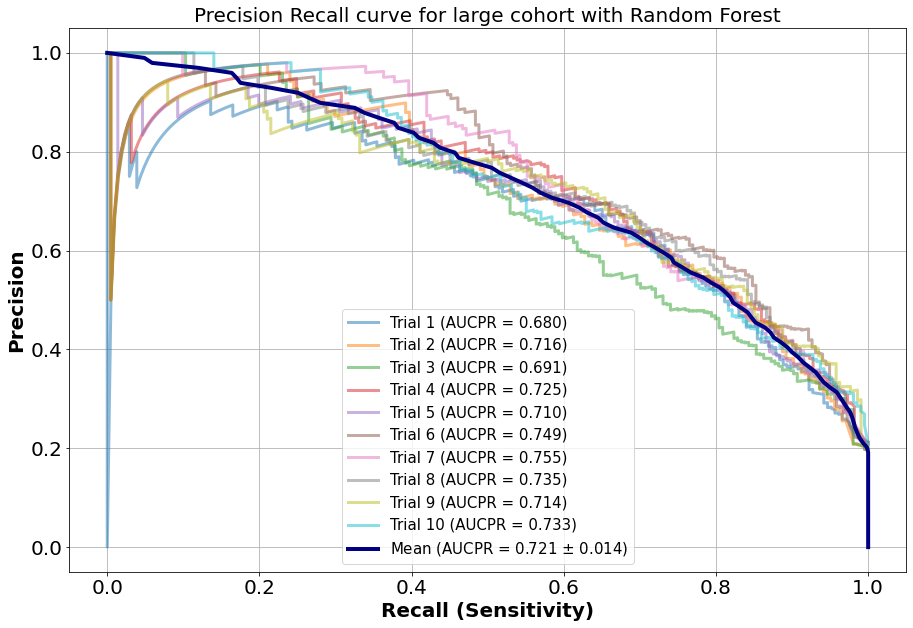

In [118]:
# defining the lists
import matplotlib.pyplot as plt
from numpy import interp
import seaborn
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)
import numpy as np
plt.figure(figsize=(15,10))
i = 0
for r in range(len(recall_total)):
        
    precision = precision_total[r]
    recall =recall_total[r]
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Trial %d (AUCPR = %0.3f)' % (i+1, pr_auc))
    i += 1
    
# plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
#mean_auc = auc(mean_recall, mean_precision)
mean_auc = np.mean(aucs)

std_auc = 1.96* np.std(aucs)/np.sqrt(len(aucs))
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

plt.title('Precision Recall curve for large cohort with Random Forest', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Precision',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 0)
plt.grid(True)
# plt.show()
plt.savefig('PRC_RF_large.png',dpi=300, bbox_inches='tight')


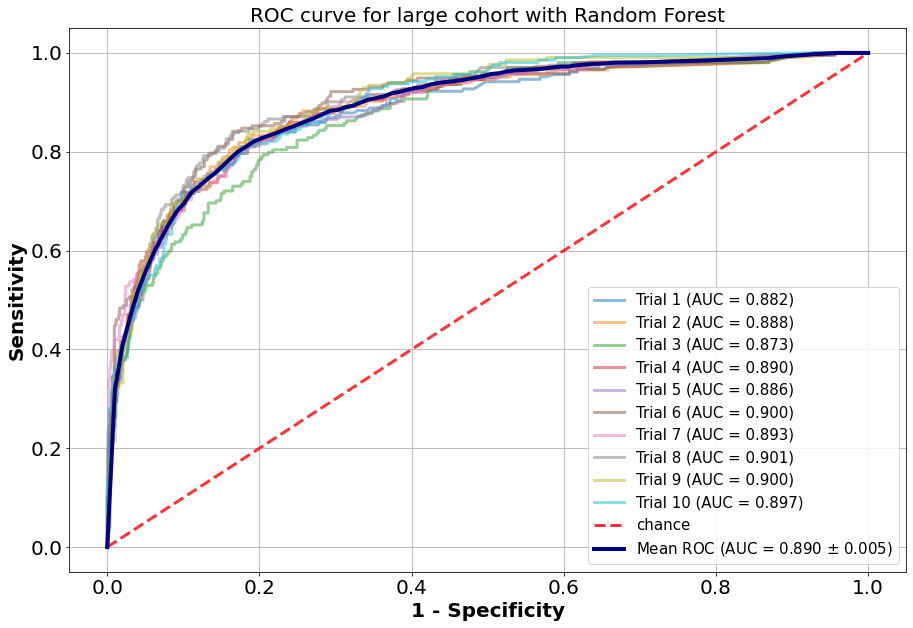

In [119]:
tprs = []
aucs = []
import matplotlib.pyplot as plt
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15,10))
i = 0

# from scipy import interp
from numpy import interp
for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='Trial %d (AUC = %0.3f)' % (i+1, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = 1.96* np.std(aucs)/np.sqrt(10)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                  label=r'$\pm$ 1 Standard Deviation')
plt.title('ROC curve for large cohort with Random Forest', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 4)
plt.savefig('ROC_RF_large.png', dpi=300, bbox_inches='tight')

#### RF with SMOTE

In [ ]:
#Cross validation using grid-search method will remove the need for splitting the samples into train, validation and test sets
#separately
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, cross_val_score, StratifiedKFold)
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import random
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc  , precision_recall_curve
import random
from sklearn.model_selection import train_test_split
import numpy as np
import random
random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc 
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
import random
#Scale the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
from sklearn import metrics
# number of trees
n_estimators = [100, 500]
    # maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = [10, 20]
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']
FeatureImportance_total =pd.DataFrame()
param_grid = {
    'bootstrap': [True],
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': [5,10],
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'criterion' : criterion  
}
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
result = pd.DataFrame()
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
                 'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
                  'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
                  'fn': make_scorer(fn) }
rf_model=RandomForestClassifier(random_state=42)
# pipe = imb_pipe([('sampling', SMOTE(sampling_strategy = 'minority',random_state=42)), ('rf', rf_model)])
pipe = imb_pipe([('UPsampling', SMOTE(sampling_strategy = 0.3,random_state=42)), \
                 ('DownSampling',RandomUnderSampler(sampling_strategy=0.5, random_state= 42))  ,\
                 ('rf', rf_model)])
hyperparameters = {'rf__' + key: param_grid[key] for key in param_grid}

fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]

for r in range(1,11):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
    clf = GridSearchCV(estimator=pipe, param_grid= hyperparameters, verbose =2,cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
    best_model = clf.fit(X_train, y_train)
    
    # retrain once on the whole training and validation data set using the best parameters
    #rf = linear_model.LogisticRegression(clf.best_params_)
    rf = best_model.best_estimator_
    
#     feature_importances = pd.DataFrame(rf.feature_importances_,index = X.columns,\
#                                    columns=['importance'])
#     print(feature_importances)
    
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    probas_=rf.predict_proba(X_test)
#   
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#   print(classification_report)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]

    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision_score(y_test, Y_pred), 'sensitivity': recall_score(y_test, Y_pred),\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#   print(classification_report)
    feature_importances = pd.DataFrame(rf[2].feature_importances_,index = X.columns,columns=['importance'])
    FeatureImportance_total = FeatureImportance_total.append(feature_importances.T)
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))
FeatureImportance_total.mean()

In [ ]:
pd.DataFrame(rf[2].feature_importances_,index = X.columns,columns=['importance'])

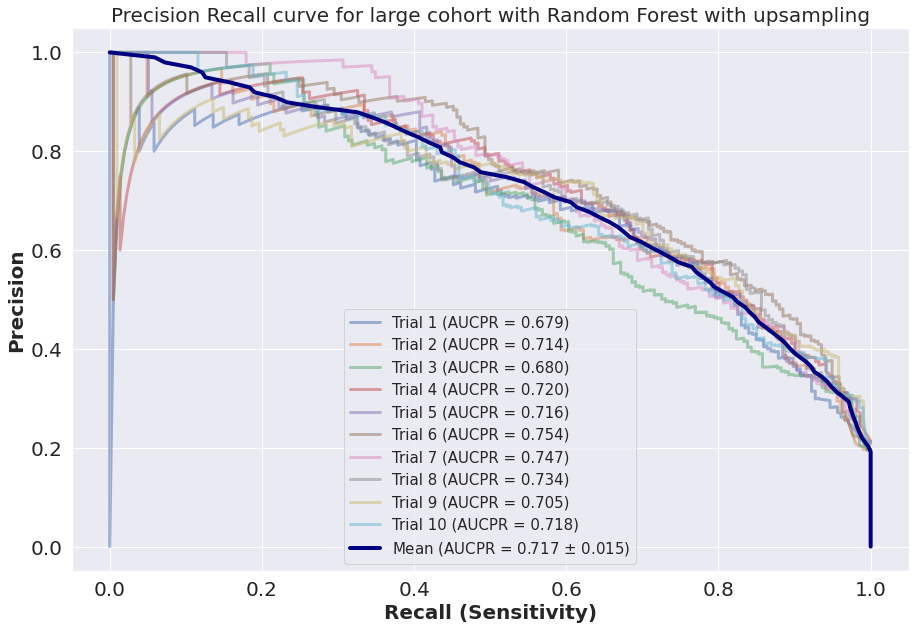

In [70]:
# defining the lists
import matplotlib.pyplot as plt
from numpy import interp
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)
import numpy as np
plt.figure(figsize=(15,10))
i = 0
for r in range(len(recall_total)):
        
    precision = precision_total[r]
    recall =recall_total[r]
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Trial %d (AUCPR = %0.3f)' % (i+1, pr_auc))
    i += 1
    
# plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
#mean_auc = auc(mean_recall, mean_precision)
mean_auc = np.mean(aucs)

std_auc = 1.96* np.std(aucs)/np.sqrt(len(aucs))
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

plt.title('Precision Recall curve for large cohort with Random Forest with upsampling', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Precision',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 0)
plt.grid(True)

plt.savefig('PRC_RF_large_RandomForest_Smote.png')


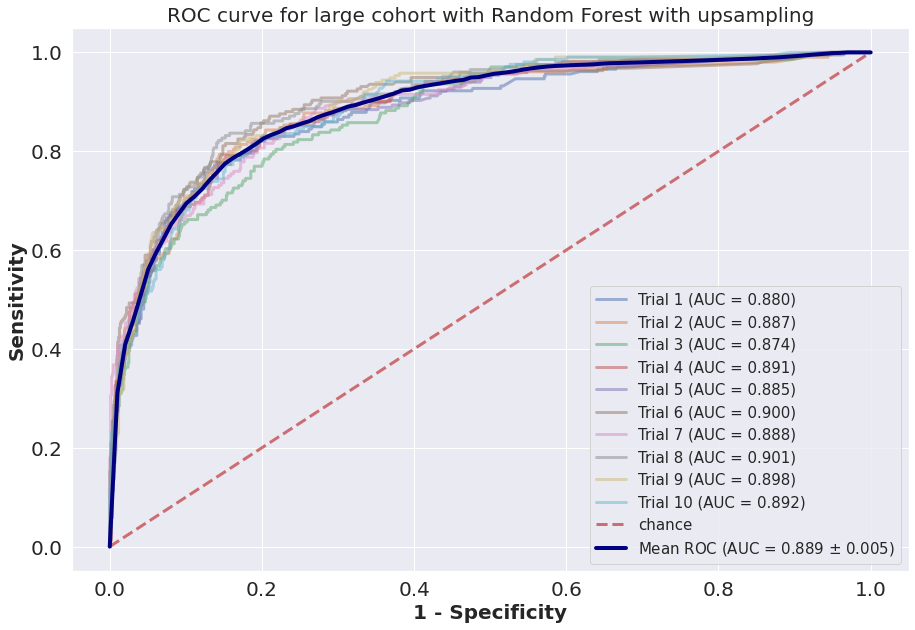

In [71]:
tprs = []
aucs = []
import matplotlib.pyplot as plt
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15,10))
i = 0

# from scipy import interp
from numpy import interp
for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='Trial %d (AUC = %0.3f)' % (i+1, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = 1.96* np.std(aucs)/np.sqrt(10)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                  label=r'$\pm$ 1 Standard Deviation')
plt.title('ROC curve for large cohort with Random Forest with upsampling', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 4)
plt.savefig('ROC_RF_large_RandomForest_Smote.png', layout = 'tight')

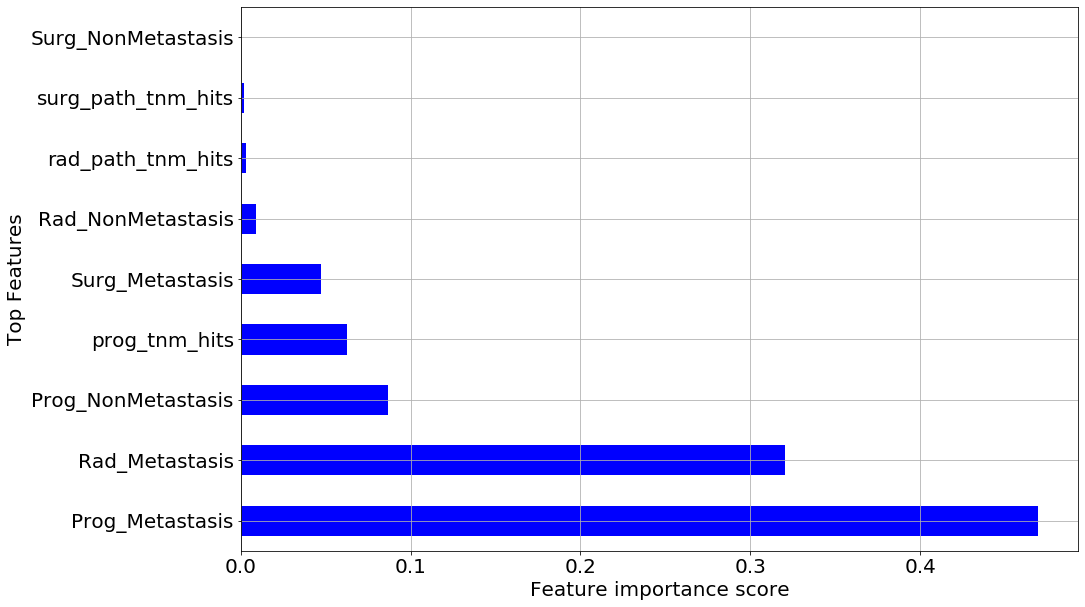

In [12]:
import matplotlib.pyplot as plt
plt.rc('font', size=20) 
plt.figure(figsize=(15,10))
# index = ['Metastasis hits from Radiology report', 'Metastasis hits from Progress report', 
# 'Stage 4 hits from Progress report', 'Stage 1 hits from Progress report', 'TNM hits from Progress report',
# 'Metastasis hits from Surgical-Pathological report', 'Stage 2 hits from Progress report', 'Stage 3 hits from Progress report',
# 'Extensive hits from Progress report', 'Advanced hits from Progress report', 'prog_stage_adv_hits,0.009180811354252263'
(pd.Series(best_model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh', color='b'))
plt.xlabel('Feature importance score', fontsize =20)
plt.ylabel('Top Features', fontsize =20)
plt.grid(True)
plt.savefig('RF_featureImp_small.png')

#### ROC and AUC

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
data = confusion_matrix(y_test,Y_pred)
df_cm = pd.DataFrame(data, columns= np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize= (10,7))
sn.set(font_scale= 1.4)
annot_kws = {"ha": 'right',"va": 'top'}
#ax = sns.heatmap(data, annot=True, annot_kws=annot_kws)
#sn.heatmap(df_cm,cmap= 'Blues',annot=True, fmt=".1f", annot_kws=annot_kws)
ax= sn.heatmap(df_cm, cmap='Blues', annot=True, fmt=".1f",annot_kws = annot_kws )


In [ ]:
# final_model = rf_random.best_estimator_
# Y_pred = final_model.predict(X_test)
# from sklearn.metrics import confusion_matrix,classification_report
# print(confusion_matrix(y_test,Y_pred))
# print("\n")
# print(classification_report(y_test,Y_pred))

# print("Training set score for RF: %f" % final_model.score(X_train , y_train))
# print("Testing  set score for RF: %f" % final_model.score(X_test  , y_test ))
# print("Accuracy:",metrics.accuracy_score(y_test, Y_pred))

In [1]:
import xgboost

###  Testing with xgboost

In [ ]:
from xgboost import XGBClassifier
#Cross validation using grid-search method will remove the need for splitting the samples into train, validation and test sets
#separately
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import roc_curve, auc  , precision_recall_curve
import random
from sklearn.metrics import accuracy_score
random_state = np.random.RandomState(42)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import random
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
from sklearn import metrics
Final_df =pd.DataFrame()
fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
result = pd.DataFrame()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01], #so called `eta` value
              'max_depth': [5,10,20],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.5, 0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [50, 100, 500], #number of trees, change it to 1000 for better results
              'seed': [1337]}
# print('Start timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
#X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size = 0.20)
for r in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state= r)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)

    xgboost_model=XGBClassifier(objective= 'binary:logistic')
#parameters = {'max_depth': range (2, 10, 1), 'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}


    gridSearch_XGboost = GridSearchCV(estimator=xgboost_model,param_grid=parameters, n_jobs = -1, cv = inner_cv, verbose=2,\
                                      scoring= scoring, refit = 'roc_auc')

    best_model = gridSearch_XGboost.fit(X_train, y_train)

    xg_clf = best_model.best_estimator_
    xg_clf.fit(X_train, y_train)
    Y_pred = xg_clf.predict(X_test)
    probas_=xg_clf.predict_proba(X_test)
#     print(classification_report(y_test,Y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    

    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision_score(y_test, Y_pred), 'sensitivity': recall_score(y_test, Y_pred),\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#     print(classification_report(y_test, Y_pred))
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))

In [ ]:
y_pred = final_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))


from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for XGBoost: %f" % final_model.score(X_train , y_train))
print("Testing  set score for XGBoost: %f" % final_model.score(X_test  , y_test ))
print("Accuracy:",metrics.accuracy_score(y_test, predictions))
from sklearn.metrics import roc_curve, auc  

probas_=final_model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, probas_[:, 1]) 
print('Area under the curve is: ', auc(fpr, tpr)) 

In [ ]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(final_model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
feat_imp

In [ ]:
feature_importances = pd.DataFrame(final_model.feature_importances_,index = X.columns,\
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
from collections import Counter
Counter(chrtDf['levels'])

In [12]:
from collections import Counter
Counter(y_test)

Counter({0: 283, 1: 65})

### Evaluation the model with SVM classifier without SMOTE

In [ ]:
#Using SVM from sklearn library
from sklearn import metrics
from sklearn import datasets
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
params_grid = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1,0.2,0.3,0.4, 0.5,1],
                     'C': [0.01,0.1,1, 10, 100]}]

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
random_state = np.random.RandomState(42)
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report

scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
result =pd.DataFrame()

fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
import numpy as np
from sklearn import metrics
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
                 'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
                  'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
                  'fn': make_scorer(fn) }
Final_df =pd.DataFrame()
svc_clf = SVC(probability=True)
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
for r in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
# cfl_model = OneVsOneClassifier(LinearSVC(random_state))
    clf = GridSearchCV(svc_clf, params_grid, cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1, verbose =2)
    best_model = clf.fit(X_train, y_train)
    

    svm_clf = clf.best_estimator_
    svm_clf.fit(X_train, y_train)
    Y_pred = svm_clf.predict(X_test)
    probas_=svm_clf.predict_proba(X_test)
#     print(classification_report(y_test,Y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    precision = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average ='macro' )[0]
    recall = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average= 'macro' )[1]

    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision, 'sensitivity': recall,\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#     print(classification_report(y_test, Y_pred))
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))

In [ ]:
print(classification_report(y_test, Y_pred))

In [ ]:
print(confusion_matrix(y_test, Y_pred))

#### plotting PRC curve

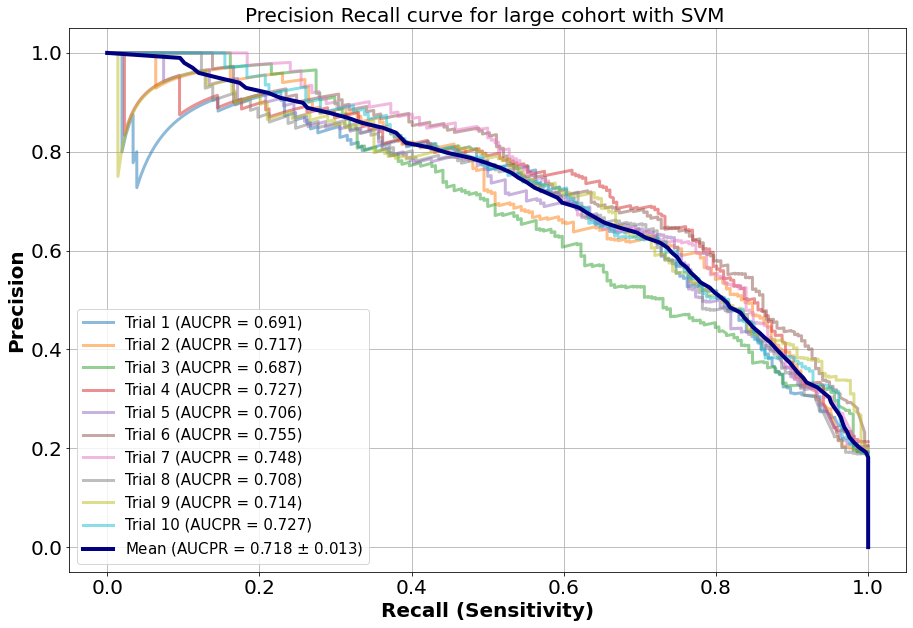

In [115]:
# defining the lists
import matplotlib.pyplot as plt
from numpy import interp
import numpy as np
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)
import numpy as np
plt.figure(figsize=(15,10))
i = 0
for r in range(len(recall_total)):
        
    precision = precision_total[r]
    recall =recall_total[r]
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Trial %d (AUCPR = %0.3f)' % (i+1, pr_auc))
    i += 1
    
# plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
#mean_auc = auc(mean_recall, mean_precision)
mean_auc = np.mean(aucs)

std_auc = 1.96* np.std(aucs)/np.sqrt(len(aucs))
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

plt.title('Precision Recall curve for large cohort with SVM ', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Precision',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 0)
plt.grid(True)
# plt.show()
plt.savefig('PRC_SVM_large.png', dpi=300, bbox_inches='tight')

#### ROC curve plot

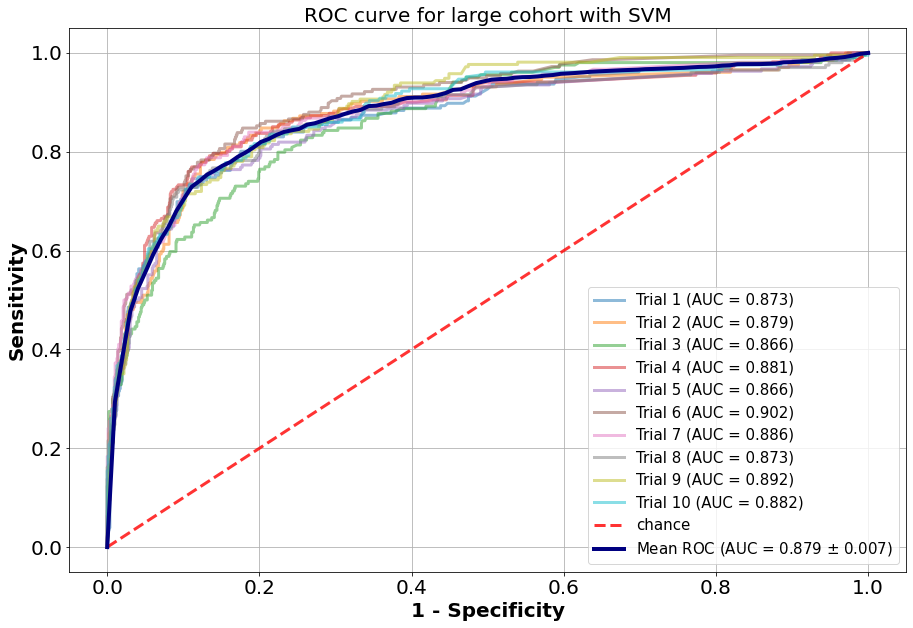

In [116]:
tprs = []
aucs = []
import matplotlib.pyplot as plt
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15,10))
i = 0

# from scipy import interp
from numpy import interp
for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='Trial %d (AUC = %0.3f)' % (i+1, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = 1.96* np.std(aucs)/np.sqrt(10)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                  label=r'$\pm$ 1 Standard Deviation')
plt.title('ROC curve for large cohort with SVM', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
plt.legend( prop={'size':15} , loc = 4)
plt.savefig('ROC_SVM_large.png', dpi=300, bbox_inches='tight')

#### SVM with upsampling

In [ ]:
#Using SVM from sklearn library
from sklearn import metrics
from sklearn import datasets
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
param_grid = {'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1,0.2,0.3,0.4, 0.5,1],
                     'C': [0.01,0.1,1, 10, 100]}

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
random_state = np.random.RandomState(42)
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)
result =pd.DataFrame()

fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
import numpy as np
from sklearn import metrics
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
                 'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
                  'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
                  'fn': make_scorer(fn) }
Final_df =pd.DataFrame()
svc_clf = SVC(probability=True)
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
#pipe = imb_pipe([('sampling', SMOTE(sampling_strategy = 'minority',random_state=42)), ('SVM', svc_clf)])
pipe = imb_pipe([('UPsampling', SMOTE(sampling_strategy = 0.3,random_state=42)), \
                 ('DownSampling',RandomUnderSampler(sampling_strategy=0.5, random_state= 42))  ,\
                 ('SVM', svc_clf)])
hyperparameters = {'SVM__' + key: param_grid[key] for key in param_grid}
for r in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
# cfl_model = OneVsOneClassifier(LinearSVC(random_state))
    
    clf = GridSearchCV(pipe, param_grid= hyperparameters, cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1, verbose =2)
    best_model = clf.fit(X_train, y_train)
    

    svm_clf = clf.best_estimator_
    svm_clf.fit(X_train, y_train)
    Y_pred = svm_clf.predict(X_test)
    probas_=svm_clf.predict_proba(X_test)
#     print(classification_report(y_test,Y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    

    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision_score(y_test, Y_pred), 'sensitivity': recall_score(y_test, Y_pred),\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#     print(classification_report(y_test, Y_pred))
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))

In [ ]:
print(classification_report(y_test, Y_pred))

#### Binary classification for Logistic regression

In [ ]:
from sklearn.model_selection import (GridSearchCV, cross_val_score, StratifiedKFold)
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
import numpy as np
import random
# random_state = np.random.RandomState(42)
from sklearn.ensemble import RandomForestClassifier
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc  
import random
import datetime
from datetime import datetime
from sklearn.svm import SVC
import sys
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, average_precision_score
print(__doc__)
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l2']
solver =['lbfgs']
# Create regularization hyperparameter space
C = np.logspace(-10, 5, 5)

# Create hyperparameter options
param_grid = dict(C=C, penalty=penalty, solver = solver)
lr= linear_model.LogisticRegression(max_iter=20000)
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True),\
                  'prc_auc': make_scorer(average_precision_score, needs_proba= True),'precision': 'precision', 'recall': 'recall',\
                 'accuracy': 'accuracy','tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
                  'fn': make_scorer(fn) }
Final_df =pd.DataFrame()
# print('Start timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
for i in range(1,10):
    
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
# Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=lr, param_grid= param_grid, cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
    print(clf.fit(X, y).best_estimator_)
    #non_nested_scores[i] = clf.best_score_
    
    # Nested CV with parameter optimization
    OuterCV =cross_validate(clf , X=X, y=y, cv=outer_cv, scoring= scoring_outercv)
   
    Final_df = Final_df.append(pd.DataFrame.from_dict(OuterCV).mean(), ignore_index= True)
# # Create grid search using 5-fold cross validation
# clf_LogisticRegression = GridSearchCV(logistic, hyperparameters, cv=cv, verbose=1, n_jobs= -1, scoring='roc_auc')
# # Fit grid search
# best_model = clf_LogisticRegression.fit(X, Y)
# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])
# #Best_Model =  pd.DataFrame.from_dict(best_model.best_estimator_.get_params())
# Model_dict = best_model.best_estimator_.get_params()
# Best_Model =  pd.DataFrame.from_dict(Model_dict, orient='index')

# #final_model = grid_rf.best_estimator_

# Y_pred = best_model.predict(X_test)

# from sklearn.metrics import confusion_matrix,classification_report


# # print(confusion_matrix(y_test,Y_pred))
# # print("\n")
# # print(classification_report(y_test,Y_pred))

# # print("Training set score for Logistic Regression: %f" % best_model.score(X_train , y_train))
# # print("Testing  set score for Logistic Regression: %f" % best_model.score(X_test  , y_test ))
# # print("Accuracy:",metrics.accuracy_score(y_test, Y_pred))

# classification_report = classification_report(y_test,Y_pred)
# probas_=best_model.predict_proba(X)
# fpr, tpr, thresholds = roc_curve(Y, probas_[:, 1]) 

# print('Start time {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
# print("Test set Accuracy: " + str(metrics.accuracy_score(y_test, Y_pred)) + '\n')
# print('Area under the curve: ' + str(auc(fpr, tpr)))

# print('End time {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
Final_df.to_csv('LR_nestedResult_large_v2.csv', index = None)

In [46]:
type(pd.DataFrame.from_dict(OuterCV).mean())

pandas.core.series.Series

#### Logistic regression without SMOTE

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, cross_val_score, StratifiedKFold)
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import random
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc  , precision_recall_curve
import random
import datetime
from datetime import datetime
from sklearn.svm import SVC
import sys
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
print(__doc__)
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l2']
solver =['lbfgs']
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
# Create regularization hyperparameter space
C = np.logspace(-10, 5, 5)
result = pd.DataFrame()
# Create hyperparameter options
param_grid = dict(C=C, penalty=penalty, solver = solver)
lr= linear_model.LogisticRegression(max_iter=20000)
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
# scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
#                  'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
#                   'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
#                   'fn': make_scorer(fn) }
Final_df =pd.DataFrame()
fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
for r in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
    clf = GridSearchCV(estimator=lr, param_grid= param_grid, cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
#     print(clf.fit(X_train, y_train).best_estimator_)
    #non_nested_scores[i] = clf.best_score_
    best_model = clf.fit(X_train, y_train)
    
    # retrain once on the whole training and validation data set using the best parameters
    #rf = linear_model.LogisticRegression(clf.best_params_)
    rf = best_model.best_estimator_
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    probas_=rf.predict_proba(X_test)
#     print(classification_report(y_test,Y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    
    precision = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average ='macro' )[0]
    recall = precision_recall_fscore_support(y_test, Y_pred, pos_label=None, average= 'macro' )[1]
    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision, 'sensitivity': recall,\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#     print(classification_report(y_test, Y_pred))
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))

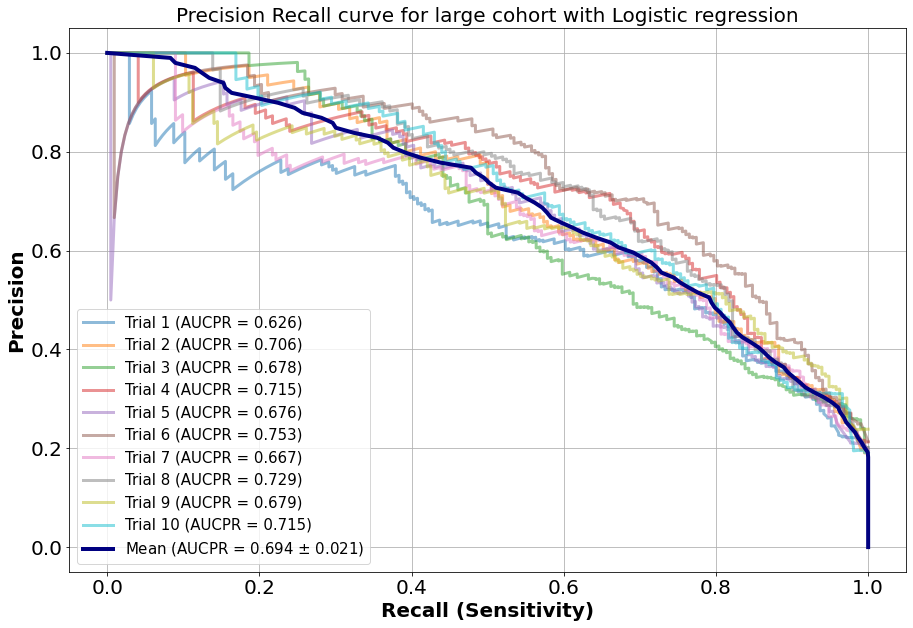

In [112]:
# defining the lists
import matplotlib.pyplot as plt
from numpy import interp
import numpy as np
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)
import numpy as np
plt.figure(figsize=(15,10))
i = 0
for r in range(len(recall_total)):
        
    precision = precision_total[r]
    recall =recall_total[r]
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Trial %d (AUCPR = %0.3f)' % (i+1, pr_auc))
    i += 1
    
# plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
#mean_auc = auc(mean_recall, mean_precision)
mean_auc = np.mean(aucs)

std_auc = 1.96* np.std(aucs)/np.sqrt(len(aucs))
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

plt.title('Precision Recall curve for large cohort with Logistic regression', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Precision',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 0)
plt.grid(True)
# plt.show()
plt.savefig('PRC_LR_large.png', dpi=300, bbox_inches='tight')

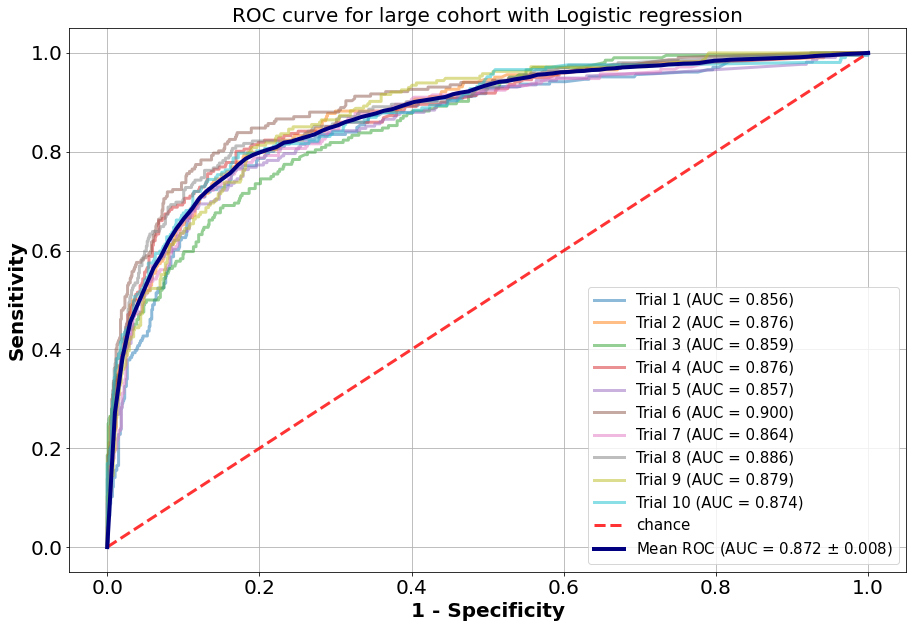

In [113]:
tprs = []
aucs = []
import matplotlib.pyplot as plt
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15,10))
i = 0

# from scipy import interp
from numpy import interp
for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='Trial %d (AUC = %0.3f)' % (i+1, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = 1.96* np.std(aucs)/np.sqrt(10)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                  label=r'$\pm$ 1 Standard Deviation')
plt.title('ROC curve for large cohort with Logistic regression', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
plt.legend( prop={'size':15} , loc = 4)
plt.savefig('ROC_LR_large.png', dpi=300, bbox_inches='tight')

In [13]:
1.96*result.std()/np.sqrt(result.shape[1])

accuracy     0.014424
prc_auc      0.046017
precision    0.051435
recall       0.040642
roc_auc      0.015827
trial        2.422625
dtype: float64

In [15]:
X.shape

(5388, 9)

#### LR with SMOTE

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (GridSearchCV, cross_val_score, StratifiedKFold)
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipe
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import random
#Choose from any scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc  , precision_recall_curve
import random
import datetime
from datetime import datetime
from sklearn.svm import SVC
import sys
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score,  make_scorer, precision_score, recall_score, \
average_precision_score, accuracy_score, average_precision_score
print(__doc__)
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l2']
solver =['lbfgs']
scoring = {'roc_auc':make_scorer(roc_auc_score, needs_proba= True)}
# Create regularization hyperparameter space
C = np.logspace(-10, 5, 5)
result = pd.DataFrame()
# Create hyperparameter options
param_grid = dict(C=C, penalty=penalty, solver = solver)

hyperparameters = {'LR__' + key: param_grid[key] for key in param_grid}
lr= linear_model.LogisticRegression(max_iter=20000)
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring_outercv= {'roc_auc':make_scorer(roc_auc_score, needs_proba= True), 'precision': 'precision', 'recall': 'recall',\
                 'accuracy': 'accuracy','prc_auc': make_scorer(average_precision_score,needs_proba=True),\
                  'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), \
                  'fn': make_scorer(fn) }
Final_df =pd.DataFrame()
# pipe = imb_pipe([('sampling', SMOTE(sampling_strategy = 'minority',random_state=42)), ('LR', lr)])
pipe = imb_pipe([('UPsampling', SMOTE(sampling_strategy = 0.3,random_state=42)), \
                 ('DownSampling',RandomUnderSampler(sampling_strategy=0.5, random_state= 42))  ,\
                 ('LR', lr)])

fpr_total =[]
tpr_total =[]
precision_total =[]
recall_total =[]
for r in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)
    clf = GridSearchCV(estimator=pipe, param_grid= hyperparameters, cv=inner_cv, scoring= scoring, refit = 'roc_auc', n_jobs=-1)
#     print(clf.fit(X_train, y_train).best_estimator_)
    #non_nested_scores[i] = clf.best_score_
    best_model = clf.fit(X_train, y_train)
    
    # retrain once on the whole training and validation data set using the best parameters
    #rf = linear_model.LogisticRegression(clf.best_params_)
    rf = best_model.best_estimator_
    rf.fit(X_train, y_train)
    Y_pred = rf.predict(X_test)
    probas_=rf.predict_proba(X_test)
#     print(classification_report(y_test,Y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) 
    fpr_total.append(fpr)
    tpr_total.append(tpr)
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, probas_[:, 1])
#     print(auc(lr_recall, lr_precision))
    precision_total.append(lr_precision)
    recall_total.append(lr_recall)
#     print(classification_report(y_test,Y_pred))
    tn = confusion_matrix(y_test, Y_pred)[0, 0]
    fp= confusion_matrix(y_test, Y_pred)[0, 1]
    fn= confusion_matrix(y_test, Y_pred)[1, 0]
    tp= confusion_matrix(y_test, Y_pred)[1, 1]
    

    data = {'trial': r,'accuracy': accuracy_score(y_test, Y_pred), 'roc_auc': roc_auc_score(y_test, probas_[:, 1]), \
            'precision':precision_score(y_test, Y_pred), 'sensitivity': recall_score(y_test, Y_pred),\
            'specificity': tn/(tn + fp)  ,'prc_auc': auc(lr_recall, lr_precision)}
    result = result.append(data, ignore_index=True)
#     print(accuracy_score(y_test, Y_pred))
#     print(roc_auc_score(y_test, Y_pred))
#     print(precision_score(y_test, Y_pred))
#     print(recall_score(y_test, Y_pred))
#   print(classification_report)
    
                                                                 
print(result.mean())
print(1.96*result.std()/np.sqrt(result.shape[0]))
# print("Training set score for LR: %f" % best_model.score(X_train , y_train))
# print("Testing  set score for LR: %f" % best_model.score(X_test  , y_test ))

Automatically created module for IPython interactive environment
accuracy       0.866512
prc_auc        0.708835
precision      0.712149
roc_auc        0.878824
sensitivity    0.550954
specificity    0.943093
trial          5.500000
dtype: float64
accuracy       0.009193
prc_auc        0.016971
precision      0.036555
roc_auc        0.006986
sensitivity    0.080692
specificity    0.011571
trial          1.876557
dtype: float64


Pipeline(steps=[('sampling',
                 SMOTE(random_state=42, sampling_strategy='minority')),
                ('LR',
                 LogisticRegression(C=0.0031622776601683794, max_iter=20000))])

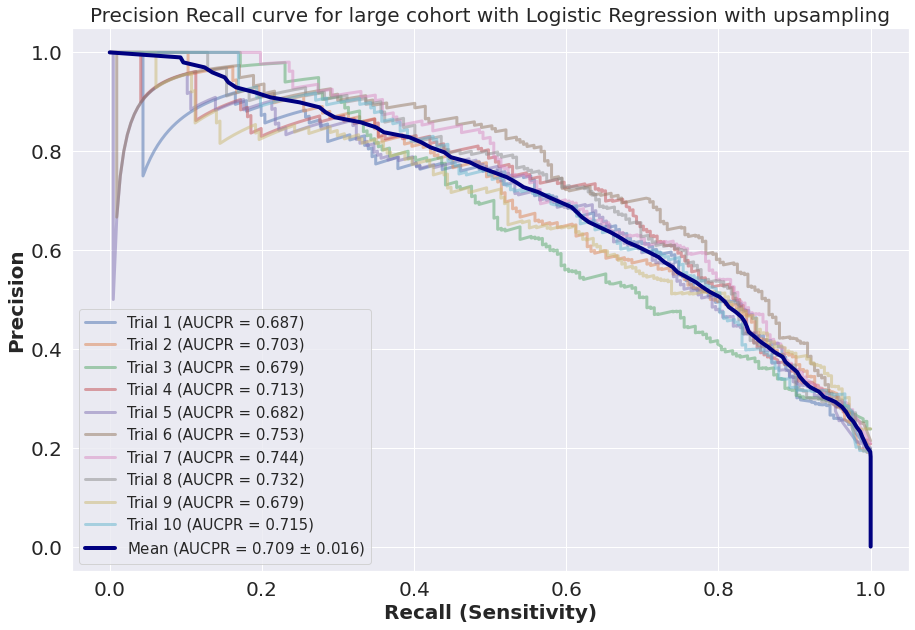

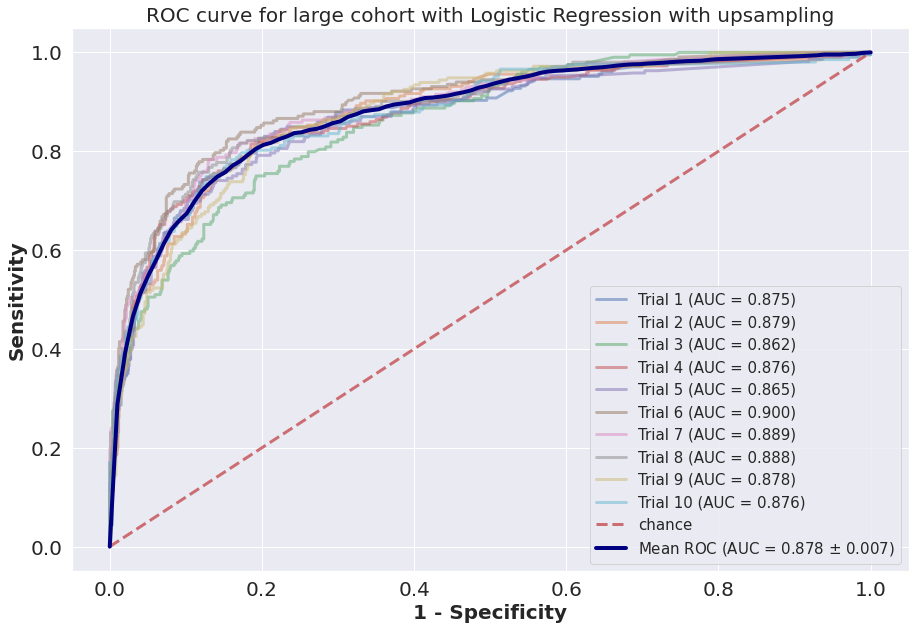

In [97]:
# defining the lists
import matplotlib.pyplot as plt
from numpy import interp
prs = []
aucs = []
mean_recall = np.linspace(0, 1, 100)
import numpy as np
plt.figure(figsize=(15,10))
i = 0
for r in range(len(recall_total)):
        
    precision = precision_total[r]
    recall =recall_total[r]
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Trial %d (AUCPR = %0.3f)' % (i+1, pr_auc))
    i += 1
    
# plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='k', label='Luck', alpha=.8)
mean_precision = np.mean(prs, axis=0)
#mean_auc = auc(mean_recall, mean_precision)
mean_auc = np.mean(aucs)

std_auc = 1.96* np.std(aucs)/np.sqrt(len(aucs))
plt.plot(mean_precision, mean_recall, color='navy',
         label=r'Mean (AUCPR = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

plt.title('Precision Recall curve for large cohort with Logistic Regression with upsampling', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall (Sensitivity)' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Precision',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 0)
plt.grid(True)

plt.savefig('PRC_LR_large_Smote.png', layout ='tight')




tprs = []
aucs = []
import matplotlib.pyplot as plt
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(15,10))
i = 0

# from scipy import interp
from numpy import interp
for j in range(len(fpr_total)):
        fpr = fpr_total[j]
        tpr = tpr_total[j]
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label='Trial %d (AUC = %0.3f)' % (i+1, roc_auc))

        i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label='chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = 1.96* np.std(aucs)/np.sqrt(10)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
         lw=4)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
#                  label=r'$\pm$ 1 Standard Deviation')
plt.title('ROC curve for large cohort with Logistic Regression with upsampling', fontsize=20)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.xlabel('1 - Specificity' ,  fontweight = "bold" , fontsize=20)
plt.ylabel('Sensitivity',fontweight = "bold" , fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend( prop={'size':15} , loc = 4)
plt.savefig('ROC_LR_large_Smote.png', layout = 'tight')

In [ ]:
import datetime
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))